# Cultural Network Simulation COVID-19 2020: Using Mesa to do agent based modeling

Written by Tim Hannigan, adapted from Mesa/NetLogo model "Virus on Network".
https://github.com/projectmesa/mesa/tree/master/examples/virus_on_network

In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from mesa.space import NetworkGrid
from mesa.batchrunner import BatchRunner

In [2]:
import igraph
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import enum

## Class methods

In [3]:
class State(enum.Enum):
    SUSCEPTIBLE = 0
    INFECTED = 1
    RESISTANT = 2

class CulturalOrientation(enum.Enum):
    COMPASSIONATE = 0
    CONCERNED = 1
    STIGMATIZING = 2
    AVOIDING = 3
    

def number_state(model, state):
     return sum([1 for actor_id,actor in model.grid.items() if actor.state is state])


def number_infected(model):
    return number_state(model, State.INFECTED)


def number_susceptible(model):
    return number_state(model, State.SUSCEPTIBLE)


def number_resistant(model):
    return number_state(model, State.RESISTANT)

# TO DO:
# capture deaths

class SocialSetting(Model):
    """A model with some number of agents"""
    def __init__(self, graph=None, initial_outbreak_size=1, virus_spread_chance=0.8,virus_check_frequency=0.4, recovery_chance=0.3, gain_resistance_chance=0.5):
        num_nodes = len(graph.vs)
        self.num_nodes = num_nodes
        self.G = graph
        self.grid = {} # managing the agents as a dict 
        self.schedule = RandomActivation(self)
        self.initial_outbreak_size = initial_outbreak_size if initial_outbreak_size <= num_nodes else num_nodes
        self.virus_spread_chance = virus_spread_chance
        self.virus_check_frequency = virus_check_frequency
        self.recovery_chance = recovery_chance
        self.gain_resistance_chance = gain_resistance_chance
        self.day=0

        self.datacollector = DataCollector({"Infected": number_infected,
                                            "Susceptible": number_susceptible,
                                            "Resistant": number_resistant})
         # Create agents
        for v in self.G.vs:
            a = SocialAgent(v.index, self, State.SUSCEPTIBLE, self.virus_spread_chance, self.virus_check_frequency,
                           self.recovery_chance, self.gain_resistance_chance, int(v['cultural_orientation']) )
            self.schedule.add(a)
            # Add agent to the grid
            self.grid[v.index]=a 

         # Infect some agents randomly as an initial state        
        infected_nodes = random.sample(list(self.G.vs), self.initial_outbreak_size)
        for v in infected_nodes:            
            self.grid[v.index].state = State.INFECTED

        self.running = True
        self.datacollector.collect(self)
        
    # TO DO
    #def resistant_susceptible_ratio(self):
    #    try:
    #        return number_state(self, State.RESISTANT) / number_state(self, State.SUSCEPTIBLE)
    #    except ZeroDivisionError:
    #        return math.inf

    def step(self):
        self.day+=1
        self.schedule.step()
        # collect data
        self.datacollector.collect(self)
        #print ("day:",self.day, " number_infected:",number_infected(model), " number_susceptible:", number_susceptible(model))

    def run_model(self, n):
        for i in range(n):
            self.step()

    def check_grid(self):# check data structure            
        for id, actor in self.grid.items():
            print (actor.unique_id, actor.state, actor.cultural_orientation)
    
    def save_graph(self, filename="graph_output.graphml"):
        self.G.vs['state'] = ""
        self.G.vs['cultural_orientation'] = ""        
        for v in self.G.vs:
            self.G.vs[v.index]['state'] = self.grid[v.index].state.name
            self.G.vs[v.index]['cultural_orientation'] = self.grid[v.index].cultural_orientation.name
        self.G.write_graphml(filename)

In [4]:
class SocialAgent(Agent):
    def __init__(self, unique_id, model, initial_state, virus_spread_chance, virus_check_frequency,
                 recovery_chance, gain_resistance_chance, cultural_orientation):
        super().__init__(unique_id, model)
        self.state = initial_state
        self.virus_spread_chance = virus_spread_chance
        self.virus_check_frequency = virus_check_frequency
        self.recovery_chance = recovery_chance
        self.gain_resistance_chance = gain_resistance_chance
        self.day_infected = 0
        
        # cultural orientation: compassionate, concerned, stigmatizing, avoiding
        self.cultural_orientation = CulturalOrientation(cultural_orientation)
        
    def try_to_infect_neighbors(self):
        neighbors_nodes = self.model.G.neighbors(self.unique_id)
        susceptible_neighbors = []
        for neighbor_node_id in neighbors_nodes:
            agent = self.model.grid[neighbor_node_id]
            if agent.state is State.SUSCEPTIBLE and agent.cultural_orientation is CulturalOrientation.COMPASSIONATE: 
                susceptible_neighbors.append(agent) # infection is then a random process (subject to virus_spread_chance)
            elif agent.state is State.SUSCEPTIBLE and agent.cultural_orientation is CulturalOrientation.CONCERNED:
                # 50% chance of susceptibility
                if self.random.random() < 0.5: susceptible_neighbors.append(agent) # infection is then a random process (subject to virus_spread_chance)
            elif agent.state is State.SUSCEPTIBLE and agent.cultural_orientation is CulturalOrientation.STIGMATIZING:
                # 10% chance of susceptibility
                if self.random.random() < 0.1: susceptible_neighbors.append(agent) # infection is then a random process (subject to virus_spread_chance)
            elif agent.state is State.SUSCEPTIBLE and agent.cultural_orientation is CulturalOrientation.AVOIDING:
                # no chance of spread
                if self.random.random() < 0.02: susceptible_neighbors.append(agent) # infection is then a random process (subject to virus_spread_chance)
                
        for a in susceptible_neighbors:
            if self.random.random() < self.virus_spread_chance:
                a.state = State.INFECTED
                a.day_infected = self.model.day

    #     def try_gain_resistance(self):
    #         if self.random.random() < self.gain_resistance_chance:
    #             self.state = State.RESISTANT

    def try_remove_infection(self):
        # Try to remove
        if (self.model.day - self.day_infected) >= 14: # Assuming 14 day recovery
            if self.random.random() < self.recovery_chance: 
                # Success            
                self.state = State.RESISTANT
            else: # Failed
                self.state = State.INFECTED
        else:
            # Failed
            self.state = State.INFECTED

    def try_check_situation(self):
        if self.state is State.INFECTED:
            self.try_remove_infection()
            

    def step(self):
        if self.state is State.INFECTED:
            self.try_to_infect_neighbors()            
        self.try_check_situation() # this is about checking and removing infection

## Helper methods

Write any helper methods here

## First step, establish network at t=0

### Randomly generated network

In [5]:
g = igraph.Graph.Erdos_Renyi(n=100, m=250)
# I am generating a random graph here, but am expecting to use Dev's graph
# Will use this network for different models
g.write_graphml("random_network.graphml")

Note: we can read in network files created externally here (ie. graph_ml or Pajek)

### Create first model from Network

In [6]:
g1 = igraph.Graph.Read_GraphML("random_network.graphml")
# configure the network with random distribution of orientations

g1.vs['cultural_orientation'] = 0 # start with default value that will be changed shortly
len_g = len(g1.vs)
cultural_orientation_dist = [None] * len_g
# allocation of compassionate, concerned, stigmatizing, avoiding
cultural_orientation_compassionate = int(len_g * .6)
cultural_orientation_concerned = int(len_g * .2)
cultural_orientation_stigmatizing = int(len_g * .1)
cultural_orientation_avoiding = int(len_g * .1)

node_list = [i for i in range(0,100)]

# random distribution
while cultural_orientation_compassionate>0:
    choice_i = random.choice(node_list)
    g1.vs[choice_i]['cultural_orientation']= CulturalOrientation.COMPASSIONATE.value # this is also 0
    # remove this node from future choice
    node_list.remove(choice_i)
    cultural_orientation_compassionate-=1 

while cultural_orientation_concerned>0:
    choice_i = random.choice(node_list)
    g1.vs[choice_i]['cultural_orientation']= CulturalOrientation.CONCERNED.value # this is also 1
    # remove this node from future choice
    node_list.remove(choice_i)
    cultural_orientation_concerned-=1 
    
while cultural_orientation_stigmatizing>0:
    choice_i = random.choice(node_list)
    g1.vs[choice_i]['cultural_orientation']= CulturalOrientation.STIGMATIZING.value # this is also 1
    # remove this node from future choice
    node_list.remove(choice_i)
    cultural_orientation_stigmatizing-=1 

while cultural_orientation_avoiding>0:
    choice_i = random.choice(node_list)
    g1.vs[choice_i]['cultural_orientation']= CulturalOrientation.AVOIDING.value # this is also 1
    # remove this node from future choice
    node_list.remove(choice_i)
    cultural_orientation_avoiding-=1 

print(g1.summary())

IGRAPH U--- 100 250 -- 
+ attr: cultural_orientation (v), id (v)


### Set up first model

In [7]:
model_1 = SocialSetting(g1, initial_outbreak_size=5, virus_spread_chance=0.9, recovery_chance=0.1)
print ("day:",model_1.day, " number_infected:",number_infected(model_1), " number_susceptible:", number_susceptible(model_1))

day: 0  number_infected: 5  number_susceptible: 95


### Run first model for 30 days

In [8]:
model_1.run_model(30)

### Gather data from model

In [9]:
data_g1 = model_1.datacollector.get_model_vars_dataframe()

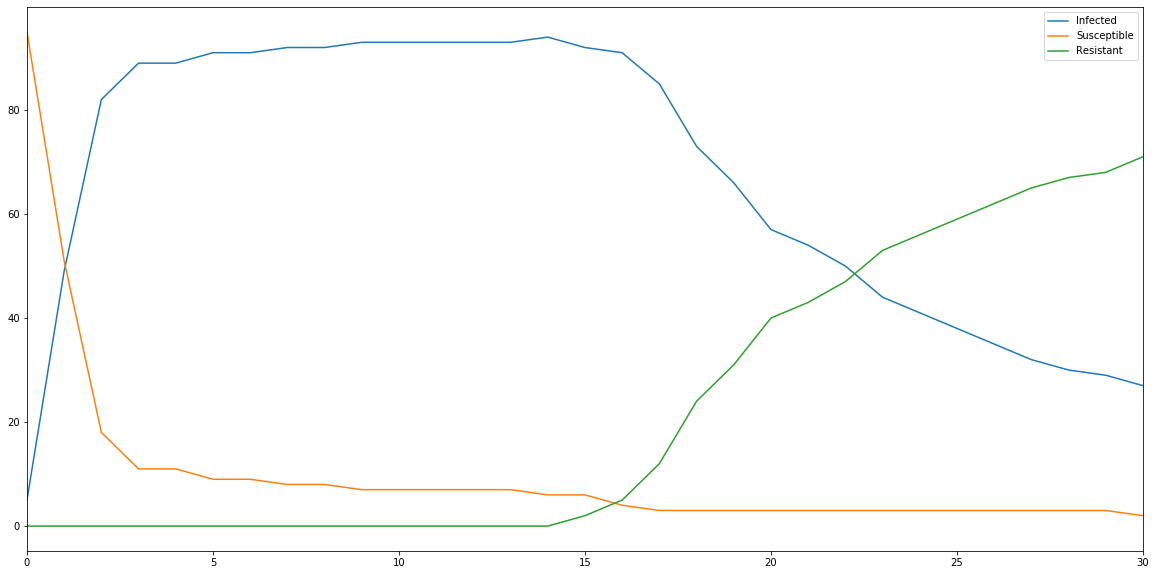

In [10]:
data_g1.plot(figsize=(20,10))

### Create second model from Network

In [11]:
g2 = igraph.Graph.Read_GraphML("random_network.graphml")
# configure the network with random distribution of orientations

g2.vs['cultural_orientation'] = 0 # start with default value, ie. everybody as COMPASSIONATE
len_g = len(g2.vs)
cultural_orientation_dist = [None] * len_g
# allocation of compassionate, concerned, stigmatizing, avoiding
cultural_orientation_compassionate = int(len_g * .1)
cultural_orientation_concerned = int(len_g * .1)
cultural_orientation_stigmatizing = int(len_g * .2)
cultural_orientation_avoiding = int(len_g * .6)

node_list = [i for i in range(0,100)]

# random distribution
while cultural_orientation_compassionate>0:
    choice_i = random.choice(node_list)
    g2.vs[choice_i]['cultural_orientation']= CulturalOrientation.COMPASSIONATE.value # this is also 0
    # remove this node from future choice
    node_list.remove(choice_i)
    cultural_orientation_compassionate-=1 

while cultural_orientation_concerned>0:
    choice_i = random.choice(node_list)
    g2.vs[choice_i]['cultural_orientation']= CulturalOrientation.CONCERNED.value # this is also 1
    # remove this node from future choice
    node_list.remove(choice_i)
    cultural_orientation_concerned-=1 
    
while cultural_orientation_stigmatizing>0:
    choice_i = random.choice(node_list)
    g2.vs[choice_i]['cultural_orientation']= CulturalOrientation.STIGMATIZING.value # this is also 1
    # remove this node from future choice
    node_list.remove(choice_i)
    cultural_orientation_stigmatizing-=1 

while cultural_orientation_avoiding>0:
    choice_i = random.choice(node_list)
    g2.vs[choice_i]['cultural_orientation']= CulturalOrientation.AVOIDING.value # this is also 1
    # remove this node from future choice
    node_list.remove(choice_i)
    cultural_orientation_avoiding-=1 


print(g2.summary())

IGRAPH U--- 100 250 -- 
+ attr: cultural_orientation (v), id (v)


### Set up second model

In [12]:
model_2 = SocialSetting(g2, initial_outbreak_size=5, virus_spread_chance=0.9, recovery_chance=0.1)
print ("day:",model_2.day, " number_infected:",number_infected(model_2), " number_susceptible:", number_susceptible(model_2))

day: 0  number_infected: 5  number_susceptible: 95


### Run second model for 30 days

In [13]:
model_2.run_model(30)

### Gather data from model

In [14]:
data_g2 = model_2.datacollector.get_model_vars_dataframe()

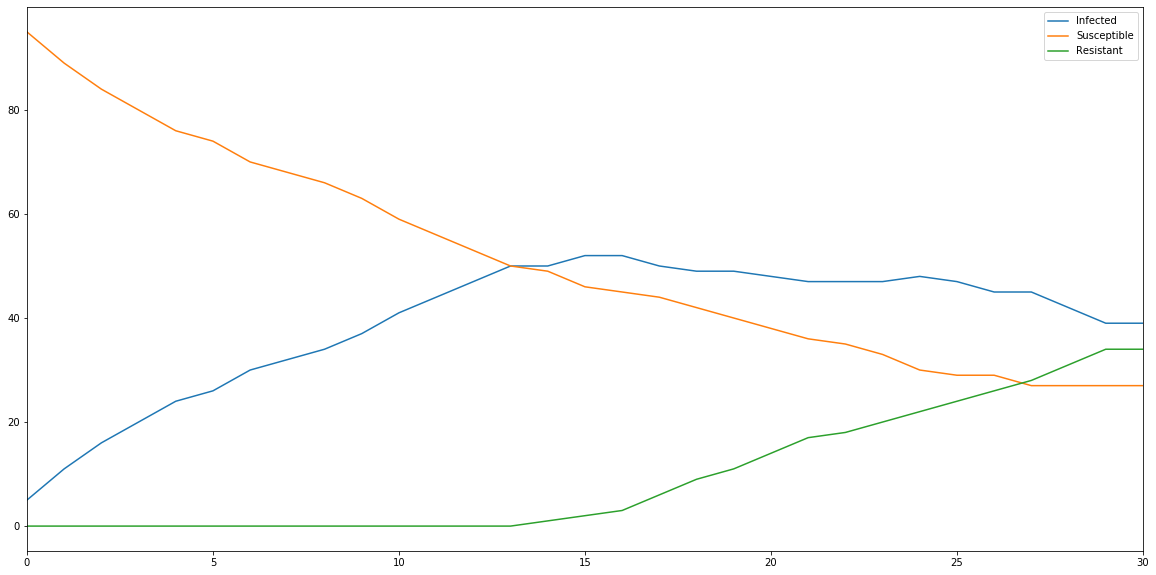

In [15]:
data_g2.plot(figsize=(20,10))

###  Combine data from both models

In [16]:
data_combined = pd.concat([data_g1['Infected'],data_g2['Infected']], axis=1, keys=['Infections_Model_1', 'Infections_Model_2'])

In [17]:
data_combined.head(5)

,Infections_Model_1,Infections_Model_2
0,5,5
1,49,11
2,82,16
3,89,20
4,89,24


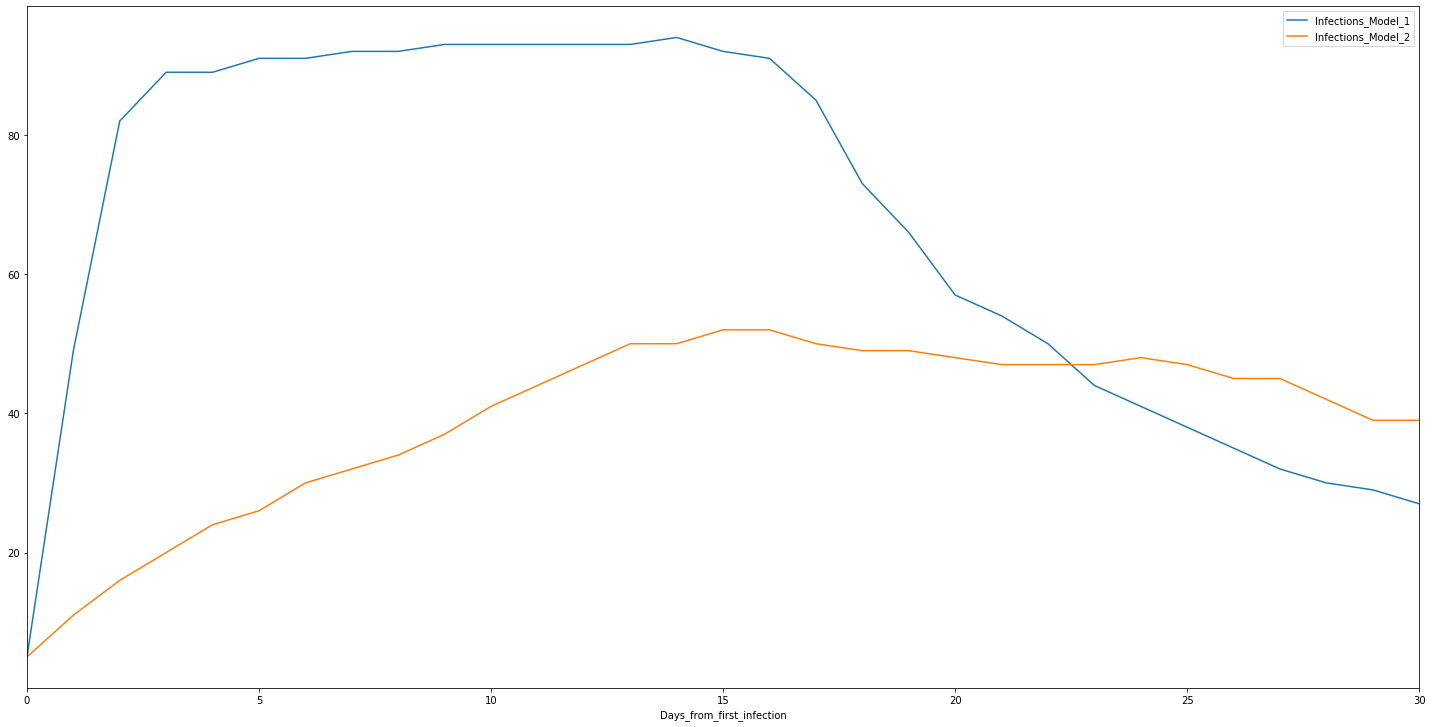

In [18]:
data_combined.plot(figsize=(20,10))
plt.tight_layout()
plt.xlabel('Days_from_first_infection')
plt.show()